In [1]:
from neucube.encoder import Delta
from neucube.validation import Pipeline
from neucube.sampler import SpikeCount
import torch

In [2]:
from tqdm import tqdm
import math
from neucube.topology import small_world_connectivity
from neucube.utils import print_summary
from neucube.training import STDP

class Reservoir_Izh():
  def __init__(self, cube_shape=(10,10,10), inputs=None, coordinates=None, mapping=None, c=0.4, l=0.169, c_in=0.9, l_in=1.2, use_mps=False):
    """
    Initializes the reservoir object.

    Parameters:
        cube_shape (tuple): Dimensions of the reservoir as a 3D cube (default: (10,10,10)).
        inputs (int): Number of input features.
        coordinates (torch.Tensor): Coordinates of the neurons in the reservoir.
                                    If not provided, the coordinates are generated based on `cube_shape`.
        mapping (torch.Tensor): Coordinates of the input neurons.
                                If not provided, random connectivity is used.
        c (float): Parameter controlling the connectivity of the reservoir.
        l (float): Parameter controlling the connectivity of the reservoir.
        c_in (float): Parameter controlling the connectivity of the input neurons.
        l_in (float): Parameter controlling the connectivity of the input neurons.
        use_mps (bool): use Metal Performance Shaders (MPS) for Apple Silicon (if available).
    """
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
    if torch.backends.mps.is_available() and use_mps is True:
      self.device = torch.device("mps:0")

    if coordinates is None:
      self.n_neurons = math.prod(cube_shape)
      x, y, z = torch.meshgrid(torch.linspace(0, 1, cube_shape[0]), torch.linspace(0, 1, cube_shape[1]), torch.linspace(0, 1, cube_shape[2]), indexing='xy')
      self.pos = torch.stack([x.flatten(), y.flatten(), z.flatten()], dim=1).to(self.device)
    else:
      self.n_neurons = coordinates.shape[0]
      self.pos = coordinates

    dist = torch.cdist(self.pos, self.pos)
    conn_mat = small_world_connectivity(dist, c=c, l=l) / 100
    inh_n = torch.randint(self.n_neurons, size=(int(self.n_neurons*0.2),))
    conn_mat[:, inh_n] = -conn_mat[:, inh_n]

    if mapping is None:
      input_conn = torch.where(torch.rand(self.n_neurons, inputs) > 0.95, torch.ones_like(torch.rand(self.n_neurons, inputs)), torch.zeros(self.n_neurons, inputs)) / 50
    else:
      dist_in = torch.cdist(coordinates, mapping, p=2)
      input_conn = small_world_connectivity(dist_in, c=c_in, l=l_in) / 50

    self.w_latent = conn_mat.to(self.device)
    self.w_in = input_conn.to(self.device)

  def simulate(self, X, mem_thr=0.1, refractory_period=5, train=True, learning_rule=STDP(), verbose=True):
    """
    Simulates the reservoir activity given input data.

    Parameters:
        X (torch.Tensor): Input data of shape (batch_size, n_time, n_features).
        mem_thr (float): Membrane threshold for spike generation.
        refractory_period (int): Refractory period after a spike.
        train (bool): Flag indicating whether to perform online training of the reservoir.
        learning_rule (LearningRule): The learning rule implementation to use for training.
        verbose (bool): Flag indicating whether to display progress during simulation.

    Returns:
        torch.Tensor: Spike activity of the reservoir neurons over time, of shape (batch_size, n_time, n_neurons).

    Raises:
        Exception: If learning rule implementation is not specified and training is enabled
    """
    if train is True and learning_rule is None:
      raise Exception("learning rule implementation must be specified if training is enabled")

    self.batch_size, self.n_time, self.n_features = X.shape

    spike_rec = torch.zeros(self.batch_size, self.n_time, self.n_neurons)

    if train is True:
      learning_rule.setup(self.device, self.n_neurons)

    for s in tqdm(range(X.shape[0]), disable = not verbose):

      spike_latent = torch.zeros(self.n_neurons).to(self.device)
      mem_poten = torch.zeros(self.n_neurons).to(self.device)
      refrac = torch.ones(self.n_neurons).to(self.device)
      refrac_count = torch.zeros(self.n_neurons).to(self.device)
      spike_times = torch.zeros(self.n_neurons).to(self.device)

      if train is True:
        learning_rule.per_sample(s)

      for k in range(self.n_time):
        spike_in = X[s,k,:]
        spike_in = spike_in.to(self.device)

        refrac[refrac_count < 1] = 1

        I = torch.sum(self.w_in*spike_in, axis=1)+torch.sum(self.w_latent*spike_latent, axis=1)
        mem_poten = mem_poten*torch.exp(torch.tensor(-(1/40)))*(1-spike_latent)+(refrac*I)

        spike_latent[mem_poten >= mem_thr] = 1
        spike_latent[mem_poten < mem_thr] = 0

        refrac[mem_poten >= mem_thr] = 0
        refrac_count[mem_poten >= mem_thr] = refractory_period
        refrac_count = refrac_count-1

        if train is True:
          learning_rule.per_time_slice(s, k)
          pre_updates, pos_updates = learning_rule.train(k-spike_times, self.w_latent, spike_latent)
          self.w_latent += pre_updates
          self.w_latent += pos_updates
          learning_rule.reset()

        spike_times[mem_poten >= mem_thr] = k
        
        spike_rec[s,k,:] = spike_latent

    return spike_rec

  def summary(self):
    """
    Prints a summary of the reservoir.
    """
    res_info = [["Neurons", str(self.n_neurons)],
                ["Reservoir connections", str(sum(sum(self.w_latent != 0)).item())],
                ["Input connections", str(sum(sum(self.w_in != 0)).item())],
                ["Device", str(self.device)]]

    print_summary(res_info)

In [3]:
import numpy as np
import pandas as pd

filenameslist = ['sam'+str(idx)+'_eeg.csv' for idx in range(1,61)]

dfs = []
for filename in filenameslist:
  dfs.append(pd.read_csv('./example_data/wrist_movement_eeg/'+filename, header=None))

fulldf = pd.concat(dfs)

labels = pd.read_csv('./example_data/wrist_movement_eeg/tar_class_labels.csv', header=None)
y = labels.values.flatten()

feat_names = pd.read_csv('./example_data/wrist_movement_eeg/feature_names_eeg.txt', header=None).values.flatten()
brain_coordinates = pd.read_csv('./example_data/wrist_movement_eeg/brain_coordinates.csv', header=None).values
eeg_mapping = pd.read_csv('./example_data/wrist_movement_eeg/eeg_mapping.csv', header=None).values

In [4]:
X = torch.tensor(fulldf.values.reshape(60,128,14))
encoder = Delta(threshold=0.8)
X = encoder.encode_dataset(X)
y = labels.values.flatten()

In [100]:
res = Reservoir_Izh(inputs=14, c=0.5, l=0.169)
w_latent = res.w_latent.cpu()
w_in = res.w_in.cpu()

In [106]:
batch_size, n_time, n_features = X.shape
n_neurons = res.n_neurons
spike_rec = torch.zeros(batch_size, n_time, n_neurons)
s = 0
mem_thr=30

for s in tqdm(range(X.shape[0])):
    a, b = torch.full((n_neurons,), 0.1, dtype=torch.float64), torch.full((n_neurons,), 0.2, dtype=torch.float64)
    c, d = torch.full((n_neurons,), -65, dtype=torch.float64), torch.full((n_neurons,), 2, dtype=torch.float64)
    mem_poten = torch.full((n_neurons,), -65, dtype=torch.float64)
    u_recvr = b*mem_poten

    spike_latent = torch.zeros(n_neurons)
    dt = 1  # Simulation time step
    T = n_time  # Total simulation time
    N = int(T / dt)  # Number of simulation steps

    mem_changes = []
    I_changes = []
    for k in range(N):
        spike_in = X[s,k,:]

        I = (torch.sum(w_in*spike_in, axis=1)+torch.sum(w_latent*spike_latent, axis=1))*550
        #I = torch.full((n_neurons,), 7.9, dtype=torch.float64)
        u_recvr = u_recvr + dt * (a * (b * mem_poten - u_recvr))
        mem_poten = mem_poten + dt * (0.04 * mem_poten**2 + 5 * mem_poten + 140 - u_recvr + I)

        mem_changes.append(mem_poten.clone())
        I_changes.append(I.clone())

        thres_met = mem_poten >= mem_thr
        mem_poten[thres_met] = c[thres_met]
        u_recvr[thres_met] = u_recvr[thres_met] + d[thres_met]

        spike_latent.fill_(0)
        spike_latent[thres_met] = 1
        
        spike_rec[s,k,:] = spike_latent

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:11<00:00,  5.24it/s]


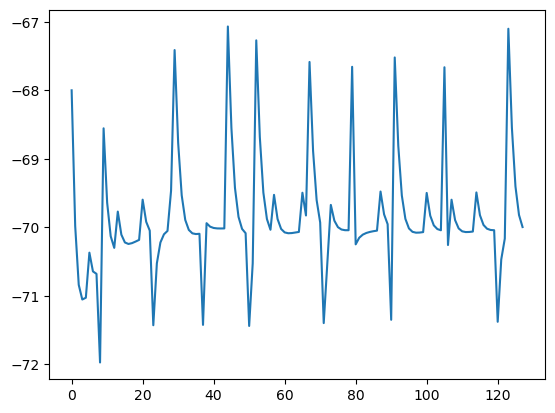

In [107]:
import matplotlib.pyplot as plt
plt.plot(np.array(mem_changes)[:,0])

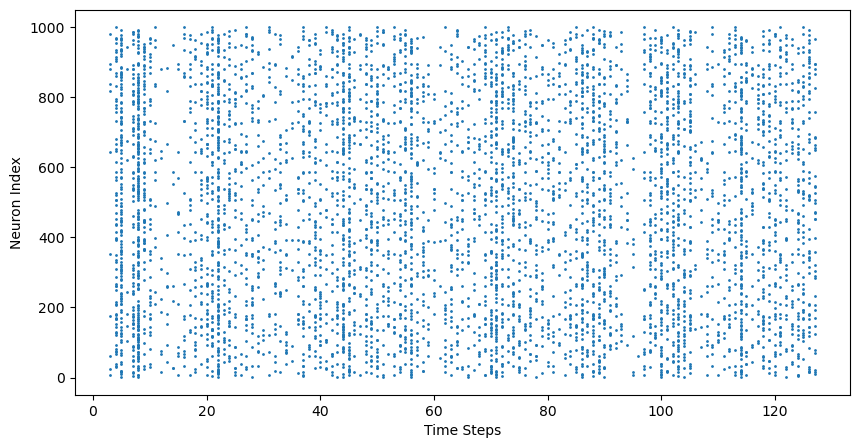

In [108]:
from neucube.visualise import spike_raster
spike_raster(spike_rec[59])

In [109]:
from neucube.sampler import DeSNN
sampler = SpikeCount()
state_vec = sampler.sample(spike_rec)
state_vec.shape

torch.Size([60, 1000])

In [110]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Define the number of folds
num_folds = 10
kf = KFold(n_splits=num_folds)

true_labels = []
predicted_labels = []

for train_index, test_index in tqdm(kf.split(state_vec)):
    X_train_fold, X_test_fold = state_vec[train_index], state_vec[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    log_reg = LogisticRegression(penalty='l1', solver='liblinear')
    log_reg.fit(X_train_fold, y_train_fold)
    y_pred = log_reg.predict(X_test_fold)
    true_labels.extend(y_test_fold)
    predicted_labels.extend(y_pred)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("10-Fold Cross-Validation Accuracy:", accuracy)
print(confusion_matrix(true_labels, predicted_labels))

10it [00:00, 14.11it/s]

10-Fold Cross-Validation Accuracy: 0.8
[[16  4  0]
 [ 6 13  1]
 [ 0  1 19]]


In [120]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

# Define the number of folds
num_folds = 10
kf = KFold(n_splits=num_folds)

true_labels = []
predicted_labels = []

for train_index, test_index in tqdm(kf.split(state_vec)):
    X_train_fold, X_test_fold = state_vec[train_index], state_vec[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    gbm = GradientBoostingClassifier(n_estimators=20, learning_rate=0.9, max_depth=2, random_state=0)
    gbm.fit(X_train_fold, y_train_fold)
    y_pred = gbm.predict(X_test_fold)
    true_labels.extend(y_test_fold)
    predicted_labels.extend(y_pred)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("10-Fold Cross-Validation Accuracy:", accuracy)
print(confusion_matrix(true_labels, predicted_labels))

0it [00:00, ?it/s]

10it [00:01,  5.61it/s]

10-Fold Cross-Validation Accuracy: 0.8
[[17  3  0]
 [ 7 12  1]
 [ 0  1 19]]
